# Project Palatio

# Setup and Ingest

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
from google.colab import auth
auth.authenticate_user()

project_id = 'palatiopage'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://palatiopage.appspot.com/
gs://staging.palatiopage.appspot.com/


In [77]:
bucketstorage = 'palatiopage.appspot.com'

!gsutil -m cp -r gs://palatiopage.appspot.com/ /content/drive/My\ Drive/data/

Copying gs://palatiopage.appspot.com/palatio.ipynb...
/ [1/1 files][  2.5 MiB/  2.5 MiB] 100% Done                                    
Operation completed over 1 objects/2.5 MiB.                                      


## Loading Libraries

In [78]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!apt install libtesseract-dev
!pip install pillow
!pip install imutils
!pip install --upgrade imutils
!pip install algorithmia
import nltk
nltk.download('popular')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[

True

In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local
import argparse
import cv2
import imutils

print('Libraries ready.')

Libraries ready.


## Loading Data

In [80]:
import io
from google.colab import files
uploaded = files.upload()

Saving FoodData.csv to FoodData (3).csv


In [81]:
dataset = pd.read_csv(io.BytesIO(uploaded['FoodData.csv']))
dataset.head()

,Class,Type,Group,Food,Allergy
0,Plant origin,Nut and seed,Oil seed,Almond,Nut Allergy
1,Plant origin,Fruit,Pome fruit,Apple,Oral Allergy Syndrome
2,Plant origin,Fruit,Stone fruit,Apricot,Stone Fruit Allergy
3,Plant origin,Vegetable,Composite vegetable,Artichoke,Insulin Allergy
4,Plant origin,Vegetable,Liliaceous vegetable,Asparagus,Allium Allergy


## Exploring Data

In [82]:
dataset.describe()

,Class,Type,Group,Food,Allergy
count,184,184,184,184,162
unique,3,14,33,183,39
top,Plant origin,Vegetable,Cruciferous vegetable,Peas,Legume Allergy
freq,146,64,15,2,14


Our dataset has 227 unique food items, and 35 unique allergies that may be triggered by them.

In [83]:
dataset['Class'].value_counts()

Plant origin      146
Animal origin      37
Mineral waters      1
Name: Class, dtype: int64

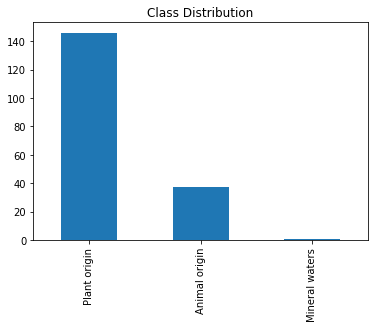

In [84]:
dataset['Class'].value_counts().plot(kind = 'bar', title = 'Class Distribution')

In [85]:
dataset['Type'].value_counts().head()

Vegetable                 64
Fruit                     34
Cereal grain and pulse    21
Aquatic animal            14
Nut and seed              12
Name: Type, dtype: int64

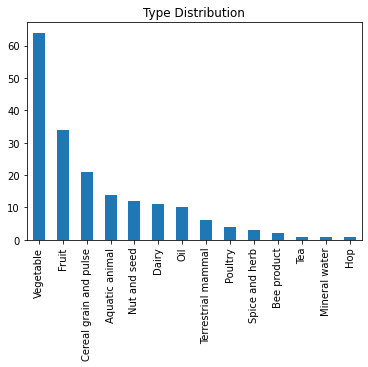

In [86]:
dataset['Type'].value_counts().plot(kind = 'bar', title = 'Type Distribution')

In [87]:
dataset['Group'].value_counts().head()

Cruciferous vegetable    15
Pulse                    13
Fish                     12
Dairy                    11
Oil seed                 10
Name: Group, dtype: int64

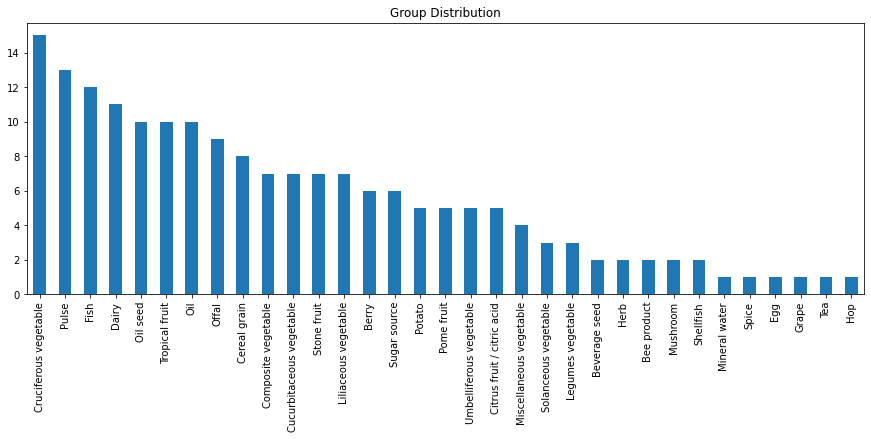

In [88]:
dataset['Group'].value_counts().plot(kind = 'bar', figsize = (15, 5), title = 'Group Distribution')

In [89]:
dataset['Allergy'].value_counts().head()

Legume Allergy                        14
Oral Allergy Syndrome                 13
Fish Allergy                          12
Milk allergy / Lactose intolerance    11
Cruciferous Allergy                    9
Name: Allergy, dtype: int64

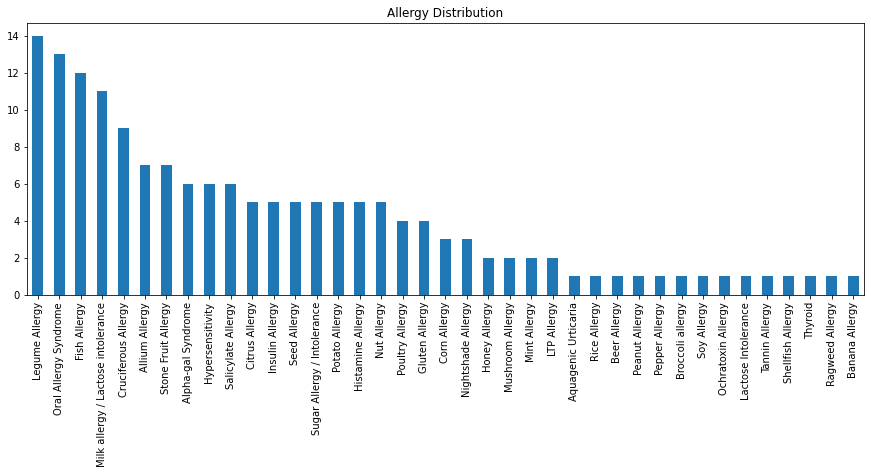

In [90]:
dataset['Allergy'].value_counts().plot(kind = 'bar', figsize = (15, 5), title = 'Allergy Distribution')

## Palatio Algorithm

### Image

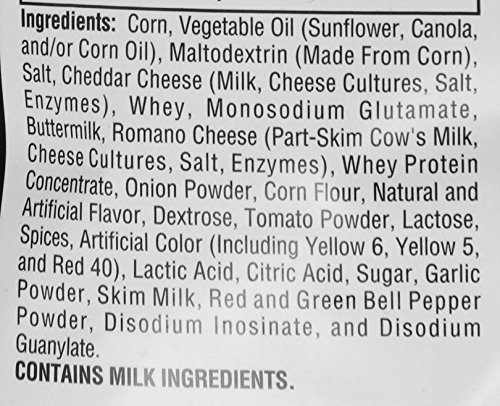

In [91]:
from google.colab.patches import cv2_imshow
im_source ='/content/drive/My Drive/data/doritos.jpg'
img = cv2.imread(im_source,0)
cv2_imshow(img)

### Extracting Text from Image

In [92]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
raw_text = pytesseract.image_to_string(img)
raw_text

"Ingredients: Corn, Vegetable Oil (Sunflower, Canola,\nand/or Corn Oil), Maltodextrin (Made From Corn),\nSalt, Cheddar Cheese (Milk, Cheese Cultures, Salt,\nEnzymes), Whey, Monosodium Glutamate,\nButtermilk, Romano Cheese (Part-Skim Cow's Milk,\nCheese Cultures, Salt, Enzymes), Whey Protein\nConcentrate, Onion Powder, Gorn Flour, Natural and\nArtificial Flavor, Dextrose, Tomato Powder, Lactose,\nSpices, Artificial Color (Including Yellow 6, Yellow 5,\nand Red 40), Lactic Acid, Citric Acid, Sugar, Garlic\nPowder, Skim Milk, Red and Green Bell Pepper\n\nPowder, Disodium Inosinate, and Disodium\nGuanylate.\n\nCONTAINS MILK INGREDIENTS.\n\x0c"

### Cleaning the obtained text

In [93]:
import re
raw_text_modified = re.sub('(ingredients)|([\/\n\.:])| ([\d]*)', ' ', raw_text.lower()).strip()
raw_text_modified

"corn, vegetable oil (sunflower, canola, and or corn oil), maltodextrin (made from corn), salt, cheddar cheese (milk, cheese cultures, salt, enzymes), whey, monosodium glutamate, buttermilk, romano cheese (part-skim cow's milk, cheese cultures, salt, enzymes), whey protein concentrate, onion powder, gorn flour, natural and artificial flavor, dextrose, tomato powder, lactose, spices, artificial color (including yellow , yellow , and red ), lactic acid, citric acid, sugar, garlic powder, skim milk, red and green bell pepper  powder, disodium inosinate, and disodium guanylate   contains milk"

In [94]:
import spacy
import nltk
from nltk.corpus import words

nlp = spacy.load('en')
doc = nlp(raw_text_modified)

# Lemmatizing the ingredients
ingredients_list = sorted(list(set([token.lemma_ for token in doc if not token.is_punct and not token.is_stop and not token.is_space and str(token.lemma_) in words.words()])))
print(ingredients_list)

['acid', 'artificial', 'bell', 'buttermilk', 'cheese', 'citric', 'color', 'concentrate', 'contain', 'corn', 'cow', 'culture', 'dextrose', 'disodium', 'enzyme', 'flavor', 'flour', 'garlic', 'green', 'include', 'lactic', 'lactose', 'maltodextrin', 'milk', 'monosodium', 'natural', 'oil', 'onion', 'pepper', 'powder', 'protein', 'red', 'salt', 'skim', 'spice', 'sugar', 'tomato', 'vegetable', 'whey', 'yellow']


We now have a list of ingredients which we will further use.

### Searching the dataset for ingredients obtained

In [95]:
data = pd.read_csv('FoodData.csv')

# Lowercasing the data
data = data.apply(lambda x: x.astype(str).str.lower())

data.head()

,Class,Type,Group,Food,Allergy
0,plant origin,nut and seed,oil seed,almond,nut allergy
1,plant origin,fruit,pome fruit,apple,oral allergy syndrome
2,plant origin,fruit,stone fruit,apricot,stone fruit allergy
3,plant origin,vegetable,composite vegetable,artichoke,insulin allergy
4,plant origin,vegetable,liliaceous vegetable,asparagus,allium allergy


In [96]:
# We have pre-sorted the 'Food' column in ascending order to be able to apply binary search for optimization
def search(ingredient, food_column):
  low = 0
  high = len(food_column) - 1
  while (low <= high): 
      mid = (low + high) // 2
  
      if (ingredient == food_column[mid] or ingredient in food_column[mid]):
          return mid
      elif (ingredient < food_column[mid]):
          high = mid - 1
      else:
          low = mid + 1

  return -1

In [97]:
import itertools

ingredients_list_copy = ingredients_list[:]
food_allergy_mapping = {}

# Storing the values of 'Food' column in a list
food_column = data['Food'].values.tolist()

def search_database(ingredients_list, food_column):
  index = 0
  while index < len(ingredients_list):
      ingredient = ingredients_list[index]
      res = search(ingredient, food_column)
      if res != -1:
        food_allergy_mapping[ingredient] = data['Allergy'][res]
        ingredients_list.remove(ingredient)
      
      index += 1

# Generating permutations of size two of the ingredients
ingredients_list_copy = list(itertools.permutations(ingredients_list, 2))
for index in range(len(ingredients_list_copy)):
  ingredients_list_copy[index] = ' '.join(ingredients_list_copy[index])

# Searching for permutations of ingredients first
search_database(ingredients_list_copy, food_column)
# Searching for individual ingredients
search_database(ingredients_list, food_column)

food_allergy_mapping

{'buttermilk': 'milk allergy / lactose intolerance',
 'corn': 'corn allergy',
 'corn oil': 'nan',
 'garlic': 'allium allergy',
 'lactose': 'lactose intolerance',
 'milk': 'milk allergy / lactose intolerance',
 'onion': 'allium allergy',
 'sugar': 'sugar allergy / intolerance',
 'vegetable': 'nan',
 'vegetable oil': 'nan'}

### Storing the Food-Allergy Dictionary in a JSON format

In [98]:
import json

json_output = json.dumps(food_allergy_mapping)
json_output

'{"corn oil": "nan", "vegetable oil": "nan", "buttermilk": "milk allergy / lactose intolerance", "corn": "corn allergy", "garlic": "allium allergy", "lactose": "lactose intolerance", "milk": "milk allergy / lactose intolerance", "onion": "allium allergy", "sugar": "sugar allergy / intolerance", "vegetable": "nan"}'